In [1]:
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

Populating the interactive namespace from numpy and matplotlib
TFP Version 0.10.0
TF  Version 2.2.0


Neural Spline Flow implementation from:

https://github.com/LukasRinder/normalizing-flows/blob/master/normalizingflows/flow_catalog.py

In [0]:
from tensorflow.keras.layers import Layer, Dense, BatchNormalization, Reshape
from tensorflow.keras import Model

class NN_Spline(Layer):
    def __init__(self, layers, k_dim, remaining_dims, first_d_dims, activation="relu"):
        super(NN_Spline, self).__init__(name="nn")
        self.k_dim = k_dim
        layer_list = []
        layer_list.append(Dense(layers[0], activation=activation, input_dim=first_d_dims, dtype=tf.float32, name=f'0_layer'))
        for i, hidden in enumerate(layers[1:]):
            layer_list.append(Dense(hidden, activation=activation, dtype=tf.float32, name=f'{i+1}_layer'))
        layer_list.append(Dense(remaining_dims*(3*k_dim-1), dtype=tf.float32, name='last_layer'))
        self.layer_list = layer_list

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        return y

class NeuralSplineFlow(tfb.Bijector):
    """
    Implementation of a Neural Spline Flows by Durkan et al. [1].
    :param n_dims: The dimension of the vector-sized input. Each individual input should be a vector with d_dim dimensions.
    :param number_of_bins: Number of bins to create the spline
    :param nn_layers: Python list-like of non-negative integers, specifying the number of units in each hidden layer.
    :param b_interval: Interval to define the spline function. Spline function behaves as identity outside of the interval
    :param d_dim: The number of dimensions to create the parameters of the spline. (d_dim-1) dims are used to create the parameters as in paper.
    :param simetric_interval: If this is true we have a interval of [-b_interval, b_interval]. [0, 2*b_interval] if false.
    """
    
    def __init__(self,input_dim, d_dim, b_interval, number_of_bins=5, nn_layers = [16, 16], n_dims=1, simetric_interval: bool = True, validate_args: bool = False, name="neural_spline_flow"):
        super(NeuralSplineFlow, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=1, name=name
        )
        
        self.event_ndims = 1
        self.total_input_dim = input_dim
        self.first_d_dims = d_dim-1
        self.remaining_dims = input_dim-self.first_d_dims
        self.number_of_bins = number_of_bins
        self.number_of_knots= number_of_bins+1
        self.b_interval = tf.constant(b_interval, dtype=tf.float32)
        self.nn = NN_Spline(layers= nn_layers, k_dim = self.number_of_bins, first_d_dims= self.first_d_dims, remaining_dims= self.remaining_dims)
        x = tf.keras.Input(self.first_d_dims, dtype=tf.float32)
        output = self.nn(x)
        self.min_bin_width = 1e-3 #maximum number of bins 1/1e-3 then...
        self.nn_model = Model(x, output, name="nn")
        self.simetric_interval = simetric_interval
        
    # some calculation could be done in one-line of code but it was preferred to explicitly write them
    # for easy debugging purposes during the development and also to give an understanding of the implementations of the terms in the paper 
    # to the reader 
    def _produce_thetas(self, x):
        thetas = self.nn_model(x)
        thetas = tf.reshape(thetas, [tf.shape(x)[0], self.remaining_dims, 3*self.number_of_bins-1])
        return thetas
    
    def _get_thetas(self, thetas, input_mask_indexes):
        thetas_for_input = tf.gather_nd(thetas, input_mask_indexes)
        thetas_1 = thetas_for_input[:, :self.number_of_bins]
        thetas_2 = thetas_for_input[:, self.number_of_bins:2*self.number_of_bins]
        thetas_3 = thetas_for_input[:, 2*self.number_of_bins:]
        return thetas_1, thetas_2, thetas_3

    
    def _bins(self, thetas, intervals):
        normalized_widths = tf.math.softmax(thetas)
        normalized_widths_filled = self.min_bin_width + (1 - self.min_bin_width * self.number_of_bins) * normalized_widths       
        expanded_widths = normalized_widths_filled * 2 * tf.expand_dims(intervals,1)
        return expanded_widths
        
    def _knots(self, bins, intervals):
        interval = -1 * tf.expand_dims(intervals,1)
        b = tf.concat([tf.zeros((tf.shape(bins)[0],1), dtype=tf.float32),  tf.dtypes.cast((tf.math.cumsum(bins, axis=1)),tf.float32)], 1) + tf.dtypes.cast(interval,tf.float32) if self.simetric_interval else tf.concat([tf.zeros((tf.shape(bins)[0],1), dtype=tf.float32),  tf.dtypes.cast((tf.math.cumsum(bins, axis=1)),tf.float32)], 1)
        return b
        
    def _derivatives(self, thetas):
        inner_derivatives = tf.math.softplus(thetas)
        c = tf.concat([tf.ones((tf.shape(inner_derivatives)[0],1), dtype=tf.float32), inner_derivatives, tf.ones((tf.shape(inner_derivatives)[0],1),dtype=tf.float32)], 1)
        return c + self.min_bin_width
        
    def _s_values(self, y_bins, x_bins):
        y = y_bins / x_bins
        return y
            
    def _knots_locations(self, x, knot_xs):
        x_binary_mask = tf.cast((tf.expand_dims(x,1) > knot_xs), tf.int32)
        knot_xs = tf.reduce_sum(x_binary_mask, axis=1)     
        return knot_xs
        
    def _indices(self, locations):
        row_indices = tf.range(tf.shape(locations)[0], dtype=tf.int32)
        z = tf.transpose(tf.stack([row_indices, locations]))        
        return z
        
    def _xi_values(self, x , knot_xs, x_bin_sizes, ind):
        f = (tf.transpose(x) - tf.gather_nd(knot_xs, ind)) / tf.gather_nd(x_bin_sizes, ind)
        return f
  
    def _g_function(self, x, bin_ind, knot_ind, xi_values, s_values, y_bin_sizes, derivatives, knot_ys):
        xi_times_1_minus_xi = xi_values * (1 - xi_values)
        s_k = tf.gather_nd(s_values, bin_ind)
        y_kplus1_minus_y_k = tf.gather_nd(y_bin_sizes, bin_ind)
        xi_square = xi_values**2
        d_k = tf.gather_nd(derivatives, bin_ind)
        d_kplus1 = tf.gather_nd(derivatives, knot_ind)
        y_k = tf.gather_nd(knot_ys,bin_ind)
        second_term_nominator = y_kplus1_minus_y_k * (s_k * xi_square + d_k * xi_times_1_minus_xi)        
        second_term_denominator =  s_k + (d_kplus1 + d_k - 2*s_k) * xi_times_1_minus_xi
        forward_val = y_k + second_term_nominator / second_term_denominator
        return forward_val
    
    def _inverse_g_function(self, input_for_inverse, floor_indices, ceil_indices, s_values, y_bin_sizes, derivatives, knot_ys, knot_xs, x_bin_sizes):
        y_minus_y_k = tf.dtypes.cast(tf.transpose(input_for_inverse), tf.float32) - tf.dtypes.cast(tf.gather_nd(knot_ys, floor_indices), tf.float32)
        s_k = tf.gather_nd(s_values,floor_indices)
        y_kplus1_minus_y_k = tf.gather_nd(y_bin_sizes, floor_indices)
        d_k = tf.gather_nd(derivatives,floor_indices)
        d_kplus1 = tf.gather_nd(derivatives,ceil_indices)
        common_term = y_minus_y_k*(d_kplus1 + d_k - 2*s_k)
        a = y_kplus1_minus_y_k * (s_k - d_k) + common_term
        b = y_kplus1_minus_y_k * d_k - common_term
        c = -1 * s_k * y_minus_y_k
        b_squared_minus_4ac = b**2 - 4 * a * c
        sqrt_b_squared_minus_4ac = tf.math.sqrt(b_squared_minus_4ac)
        denominator = (-1 * b - sqrt_b_squared_minus_4ac)
        xi_x_d_to_D = 2 * c / denominator
        x_d_to_D = xi_x_d_to_D * tf.gather_nd(x_bin_sizes, floor_indices) + tf.gather_nd(knot_xs, floor_indices)
        return x_d_to_D
    
    def _derivative_of_g_func(self, x, floor_indices, ceil_indices, xi_values, s_values, derivatives):
        one_minus_xi = (1 - xi_values)
        xi_times_1_minus_xi = xi_values * one_minus_xi
        s_k = tf.gather_nd(s_values, floor_indices)
        one_minus_xi_square = one_minus_xi**2
        d_k = tf.gather_nd(derivatives, floor_indices)
        d_kplus1 = tf.gather_nd(derivatives, ceil_indices)
        nominator = s_k**2 * (d_kplus1*(xi_values**2) + 2*s_k*xi_times_1_minus_xi + d_k*one_minus_xi_square)
        denominator = (s_k + (d_kplus1 + d_k - 2*s_k)*xi_times_1_minus_xi)**2
        derivative_result = nominator/denominator
        return derivative_result
    
    
    def _data_mask(self, x_d_to_D, interval):
        less_than_right_limit_mask = tf.less(x_d_to_D, interval)      
        bigger_than_left_limit_mask = tf.greater(x_d_to_D, -1.0 * interval)
        input_mask = less_than_right_limit_mask & bigger_than_left_limit_mask
        return input_mask
    
    def _forward(self, x):
        x_1_to_d, x_d_to_D = x[:,:self.first_d_dims], x[:,self.first_d_dims:]
        x_d_to_D = tf.constant(x_d_to_D, dtype=tf.float32)
        x_1_to_d = tf.constant(x_1_to_d, dtype=tf.float32)
        _, intervals_for_func = self.b_interval[:self.first_d_dims], self.b_interval[self.first_d_dims:]
        y_1_to_d = x_1_to_d
        input_mask = self._data_mask(x_d_to_D, intervals_for_func)

        def return_identity(): return x
        
        def return_result():  
            output = tf.zeros(tf.shape(x_d_to_D))
            input_mask_indexes = tf.where(input_mask)
            neg_input_mask_indexes = tf.where(~input_mask)
            thetas = self._produce_thetas(x_1_to_d)
            thetas_1, thetas_2, thetas_3 = self._get_thetas(thetas, input_mask_indexes)   
            interval_indices = input_mask_indexes[:,1]
           
            input_for_spline = x_d_to_D[input_mask]
            intervals_for_input = tf.gather(intervals_for_func, interval_indices)            
            x_bin_sizes = self._bins(thetas_1,intervals_for_input)  
            knot_xs = self._knots(x_bin_sizes, intervals_for_input)  
            y_bin_sizes = self._bins(thetas_2,intervals_for_input) 
            knot_ys = self._knots(y_bin_sizes, intervals_for_input)
            derivatives = self._derivatives(thetas_3)
            locs = self._knots_locations(input_for_spline, knot_xs)
            floor_indices = self._indices(locs-1)            
            ceil_indices = self._indices(locs)
            xi_values = self._xi_values(input_for_spline , knot_xs, x_bin_sizes, floor_indices)
            s_values = self._s_values(y_bin_sizes, x_bin_sizes)
            forward_val = self._g_function(input_for_spline, floor_indices, ceil_indices, xi_values, s_values, y_bin_sizes, derivatives, knot_ys)
            output = tf.tensor_scatter_nd_update(tf.dtypes.cast(tf.expand_dims(output,2), dtype=tf.float32), input_mask_indexes, tf.expand_dims(tf.dtypes.cast(tf.transpose(forward_val),dtype=tf.float32), 1))
            output = tf.tensor_scatter_nd_update(output, neg_input_mask_indexes, tf.expand_dims(x_d_to_D[~input_mask],1))
            return output
        
        #these conditions are used in order to be able to use tf.function however
        #it didn't work with tf.function.
        r = tf.cond(tf.equal(tf.reduce_any(input_mask), tf.constant(False)), return_identity, return_result)
        y = tf.concat([y_1_to_d, tf.squeeze(r,-1)], axis=-1)
        return y        

    def _inverse(self, y):
        y_1_to_d, y_d_to_D = y[:,:self.first_d_dims], y[:,self.first_d_dims:]
        _, intervals_for_func = self.b_interval[:self.first_d_dims], self.b_interval[self.first_d_dims:]        
        x_1_to_d = y_1_to_d
        input_mask = self._data_mask(y_d_to_D, intervals_for_func)

        def return_identity(): 
            return y
        
        def return_result():
            output = tf.zeros(tf.shape(y_d_to_D), dtype=tf.float32)            
            input_mask_indexes = tf.where(input_mask)
            neg_input_mask_indexes = tf.where(~input_mask)            
            thetas = self._produce_thetas(y_1_to_d)
            thetas_1, thetas_2, thetas_3 = self._get_thetas(thetas, input_mask_indexes)
            input_for_inverse = y_d_to_D[input_mask]
            interval_indices = input_mask_indexes[:,1]

            intervals_for_input = tf.gather(intervals_for_func, interval_indices)               
            x_bin_sizes = self._bins(thetas_1, intervals_for_input)            
            knot_xs = self._knots(x_bin_sizes, intervals_for_input)              
            y_bin_sizes = self._bins(thetas_2, intervals_for_input) 
            knot_ys = self._knots(y_bin_sizes, intervals_for_input)
            derivatives = self._derivatives(thetas_3)
            locs = self._knots_locations(input_for_inverse, knot_ys)
            floor_indices = self._indices(locs-1)
            ceil_indices = self._indices(locs)            
            s_values = self._s_values(y_bin_sizes, x_bin_sizes)

            inverse_val = self._inverse_g_function(input_for_inverse, floor_indices, ceil_indices, s_values, y_bin_sizes, derivatives, knot_ys, knot_xs, x_bin_sizes)
            output = tf.tensor_scatter_nd_update(tf.dtypes.cast(tf.expand_dims(output,2), dtype=tf.float32), input_mask_indexes, tf.expand_dims(tf.dtypes.cast(tf.transpose(inverse_val), dtype=tf.float32),1))
            output = tf.tensor_scatter_nd_update(tf.dtypes.cast(output, dtype=tf.float32), neg_input_mask_indexes, tf.dtypes.cast(tf.expand_dims(y_d_to_D[~input_mask],1), tf.float32))
            return tf.concat([tf.dtypes.cast(y_1_to_d, tf.float32), tf.dtypes.cast(tf.squeeze(output,-1), tf.float32)], axis=-1)
        
        return tf.cond(tf.equal(tf.reduce_any(input_mask), tf.constant(False)), return_identity, return_result)
        
        
    def _forward_log_det_jacobian(self, x, thetas=None):
        x_1_to_d, x_d_to_D = x[:,:self.first_d_dims], x[:,self.first_d_dims:]
        _, intervals_for_func = self.b_interval[:self.first_d_dims], self.b_interval[self.first_d_dims:]                
        input_mask = self._data_mask(x_d_to_D, intervals_for_func)
        def return_identity_log_det(): return tf.constant(0.0, dtype=tf.float32)
        
        def return_result_log_det():
            input_mask_indexes = tf.where(input_mask)            
            neg_input_mask_indexes = tf.where(~input_mask)
            thetas =  self._produce_thetas(x_1_to_d)
            thetas_1, thetas_2, thetas_3 = self._get_thetas(thetas, input_mask_indexes)    
            interval_indices = input_mask_indexes[:,1]
            intervals_for_input = tf.gather(intervals_for_func, interval_indices) 
            input_for_derivative = x_d_to_D[input_mask]
            x_bin_sizes = self._bins(thetas_1, intervals_for_input)
            knot_xs = self._knots(x_bin_sizes, intervals_for_input)  
            y_bin_sizes = self._bins(thetas_2, intervals_for_input)
            knot_ys = self._knots(y_bin_sizes, intervals_for_input)
            derivatives = self._derivatives(thetas_3)
            locs = self._knots_locations(input_for_derivative, knot_xs)
            floor_indices = self._indices(locs-1)
            ceil_indices = self._indices(locs)
            s_values = self._s_values(y_bin_sizes, x_bin_sizes)
            xi_values = self._xi_values(input_for_derivative, knot_xs, x_bin_sizes, floor_indices)       
            dervs = self._derivative_of_g_func(input_for_derivative, floor_indices, ceil_indices, xi_values, s_values, derivatives)            
            output = tf.ones(tf.shape(x), dtype=tf.float32)        
            squeezed = tf.tensor_scatter_nd_update(tf.dtypes.cast(tf.expand_dims(output,2), dtype=tf.float32), input_mask_indexes, tf.expand_dims(tf.transpose(tf.dtypes.cast(dervs,dtype=tf.float32)),1))
            output = tf.squeeze(squeezed)            
            log_dervs = tf.math.log(output)            
            log_det_sum = tf.reduce_sum(log_dervs, axis=1)     
            return log_det_sum
        
        r = tf.cond(tf.equal(tf.reduce_any(input_mask), tf.constant(False)), return_identity_log_det, return_result_log_det)
        return r
    
    def _inverse_log_det_jacobian(self, y):
        neg_for_log_det = -1*self._forward_log_det_jacobian(self._inverse(y))
        return neg_for_log_det

In [3]:
class NSFLayer(tf.keras.models.Model):
    def __init__(self, *, input_dim, **kwargs):
        super().__init__(**kwargs)

        layers = 8
        shape = [32, 32]

        bijector_chain = []
        for i in range(layers):
            bijector_chain.append(NeuralSplineFlow(input_dim=2, d_dim=2, number_of_bins=32, nn_layers = shape, b_interval= [2, 2]))
            bijector_chain.append(tfp.bijectors.Permute([1, 0]))

        bijector = tfb.Chain(bijectors=list(reversed(bijector_chain)), name='chain_of_real_nvp')

        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=tf.zeros(2), scale_identity_multiplier=1.0),
            bijector = bijector)

    def call(self, *inputs):
        return self.flow.bijector.forward(*inputs)

from sklearn import cluster, datasets, mixture

batch_size = 1024
X = datasets.make_moons(n_samples=batch_size, noise=.05)[0].astype(np.float32)

print(X.shape, X.dtype)
model = NSFLayer(input_dim=2)

_ = model(X) 
model.summary()

print('done')

(1024, 2) float32
Model: "nsf_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
done


In [0]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(5e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)


@tf.function #Adding the tf.function makes it about 10 times faster!!!
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

In [5]:
from time import time
start = time()
for i in range(10):
    ims = datasets.make_moons(n_samples=batch_size, noise=.05)[0].astype(np.float32)
    loss = train_step(ims)
    if (i % 1 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   2.7066903 49.8228325843811
1   2.7062764 0.05036664009094238
2   2.7460852 0.04855608940124512
3   2.7080464 0.048781394958496094
4   2.743662 0.04992866516113281
5   2.6881385 0.05284881591796875
6   2.7694154 0.05014920234680176
7   2.7300363 0.04880166053771973
8   2.6952066 0.04961228370666504
9   2.7192972 0.061121225357055664


In [0]:
def train_density_no_tf(distribution, optimizer, batch):
    """
    Train function for density estimation normalizing flows without tf.function decorator
    :param distribution: TensorFlow distribution, e.g. tf.TransformedDistribution.
    :param optimizer: TensorFlow keras optimizer, e.g. tf.keras.optimizers.Adam(..)
    :param batch: Batch of the train data.
    :return: loss.
    """
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(distribution.log_prob(batch)) # negative log likelihood
        gradients = tape.gradient(loss, distribution.trainable_variables)
        optimizer.apply_gradients(zip(gradients, distribution.trainable_variables))
        return loss

In [7]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = 1000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
batch_size = 1024

from sklearn import cluster, datasets, mixture
from time import time
start = time()

# start training
for i in range(max_epochs):
    batch = datasets.make_moons(n_samples=batch_size, noise=.05)[0].astype(np.float32)
    loss = train_density_no_tf(model.flow, optimizer, batch)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

Instructions for updating:
Use tf.identity instead.
0   2.7034178 1.1666924953460693
100   1.0053544 102.95524215698242
200   0.646474 101.87658333778381
300   0.51365614 101.86145424842834
400   0.5117297 102.85974168777466
500   0.45845956 105.4496545791626
600   0.42963085 102.5119948387146
700   0.43359163 110.00307583808899
800   0.44620603 109.30544948577881
900   0.37829643 106.67638373374939


In [8]:
#model(X)
xc,yc = meshgrid(linspace(-1.5,2.5,128),linspace(-1.,1.5,128))
Z = stack([xc.flatten(), yc.flatten()],axis=1).astype('float32')
print(Z.shape, Z.dtype)

S = model.flow.log_prob(Z)

#S = model.flow.log_prob(Z)
print(S.shape, S.dtype)

(16384, 2) float32
(16384,) <dtype: 'float32'>


(16384,) <class 'numpy.ndarray'> float32


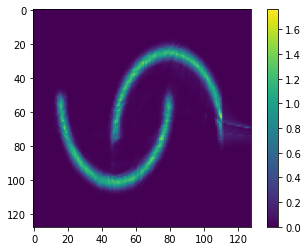

In [9]:
S = S.numpy()
print(S.shape, type(S), S.dtype)
imshow(exp(S.reshape((128,128)))); colorbar()